# Deep Fake Image Detection


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.preprocessing import image
import seaborn as sns
from sklearn import metrics

In [ ]:
tf.keras.backend.clear_session() #clean session

# Data Loading


In [26]:
main_path = '/kaggle/input/fake-images/dataset'

train_dir = os.path.join(main_path, 'train')
valid_dir = os.path.join(main_path, 'validation')
test_dir = os.path.join(main_path, 'test')

In [27]:
print("Train_dir Subfolders: ", os.listdir(train_dir))
print("Valid_dir Subfolders: ", os.listdir(valid_dir))
print("Test_dir Subfolders: ", os.listdir(test_dir))

Train_dir Subfolders:  ['fake', 'real']
Valid_dir Subfolders:  ['fake', 'real']
Test_dir Subfolders:  ['fake', 'real']


# Short EDA - Exploratory Data Analysis


In [28]:
images_df = {
    "folder":[],
    "image_path":[],
    "label":[]
}

for folder in os.listdir(main_path): #iterate on each train, valid and test folder
    for label in os.listdir(main_path + "/" + folder): #iterate on fake and real folders (labels)
        for img in glob.glob(main_path + "/" + folder + "/" + label + "/*.jpg"):
            images_df["folder"].append(folder)
            images_df["image_path"].append(img)
            images_df["label"].append(label)

In [29]:
images_df = pd.DataFrame(images_df)

In [6]:
images_df

folder                                         image_path label
0     validation  /kaggle/input/fake-images/dataset/validation/f...  fake
1     validation  /kaggle/input/fake-images/dataset/validation/f...  fake
2     validation  /kaggle/input/fake-images/dataset/validation/f...  fake
3     validation  /kaggle/input/fake-images/dataset/validation/f...  fake
4     validation  /kaggle/input/fake-images/dataset/validation/f...  fake
...          ...                                                ...   ...
7863       train  /kaggle/input/fake-images/dataset/train/real/0...  real
7864       train  /kaggle/input/fake-images/dataset/train/real/0...  real
7865       train  /kaggle/input/fake-images/dataset/train/real/0...  real
7866       train  /kaggle/input/fake-images/dataset/train/real/0...  real
7867       train  /kaggle/input/fake-images/dataset/train/real/0...  real

[7868 rows x 3 columns]

In [30]:
real_grouped_df = images_df[images_df['label'] == "real"].groupby('folder')
fake_grouped_df = images_df[images_df['label'] == "fake"].groupby('folder')

In [31]:
real_grouped_df.size()

folder
test           334
train         3000
validation     600
dtype: int64

In [9]:
fake_grouped_df.size()

folder
test           334
train         3000
validation     600
dtype: int64

In [32]:
image_train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
                                  rescale=1./255.,
                                  horizontal_flip=True,
                                  )

image_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)

In [33]:
train_ds = image_train_gen.flow_from_directory(
    train_dir,
    target_size=(256, 256),
    batch_size=64,
    class_mode='binary',
)

valid_ds = image_gen.flow_from_directory(
    valid_dir,
    target_size=(256, 256),
    batch_size=64,
    class_mode='binary'
)

test_ds = image_gen.flow_from_directory(
    test_dir,
    target_size=(256, 256),
    batch_size=64,
    class_mode='binary',
    shuffle=False) #shuffle disabled

Found 6000 images belonging to 2 classes.
Found 1200 images belonging to 2 classes.
Found 668 images belonging to 2 classes.


# Data Visualization


In [34]:
for img, label in train_ds:
    print("Values: ", img[0])
    print("Label: ", label[0])
    break

Values:  [[[0.9176471  0.9215687  0.9294118 ]
  [0.9176471  0.9215687  0.9294118 ]
  [0.9176471  0.9215687  0.9294118 ]
  ...
  [0.2392157  0.34509805 0.7019608 ]
  [0.32156864 0.48627454 0.81568635]
  [0.24705884 0.43529415 0.7568628 ]]

 [[0.9215687  0.92549026 0.9333334 ]
  [0.9215687  0.92549026 0.9333334 ]
  [0.9215687  0.92549026 0.9333334 ]
  ...
  [0.24705884 0.37254903 0.7137255 ]
  [0.43137258 0.5882353  0.9215687 ]
  [0.29411766 0.47058827 0.7960785 ]]

 [[0.92549026 0.9294118  0.93725497]
  [0.92549026 0.9294118  0.93725497]
  [0.92549026 0.9294118  0.93725497]
  ...
  [0.2627451  0.42352945 0.74509805]
  [0.2901961  0.43137258 0.7686275 ]
  [0.13725491 0.27058825 0.6117647 ]]

 ...

 [[0.5137255  0.50980395 0.43137258]
  [0.5058824  0.5019608  0.42352945]
  [0.49411768 0.4901961  0.41176474]
  ...
  [0.49411768 0.49411768 0.40000004]
  [0.49803925 0.49411768 0.41176474]
  [0.5019608  0.49803925 0.4156863 ]]

 [[0.5019608  0.49803925 0.4156863 ]
  [0.49411768 0.4901961  0.4

In [13]:
for img, label in train_ds:
    print(img.shape)
    print(label.shape)
    break

(64, 256, 256, 3)
(64,)


In [14]:
train_ds.class_indices

{'fake': 0, 'real': 1}

# CNN model architecture (DenseNet121)


In [35]:
input_shape = (256, 256, 3) #define the input shape of our data

In [36]:
#create the model's architecture and compile it
def get_model(input_shape):

    input = tf.keras.Input(shape=input_shape)

    densenet = tf.keras.applications.DenseNet121( weights="imagenet", include_top=False, input_tensor = input)

    x = tf.keras.layers.GlobalAveragePooling2D()(densenet.output)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(x) #binary classification

    model = tf.keras.Model(densenet.input, output)

    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

    return model


In [37]:
model_ft = get_model(input_shape)

model_ft.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_2    │ (None, 262, 262,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,408 │ zero_padding2d_2… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_3    │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 64, 64,    │          0 │ zero_padding2d_3… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 64, 64,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 64, 64,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 64, 64,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 64, 64,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 64, 64,    │     12,288 │ conv2_block2_0_r

 Total params: 7,564,865 (28.86 MB)

 Trainable params: 7,480,193 (28.53 MB)

 Non-trainable params: 84,672 (330.75 KB)

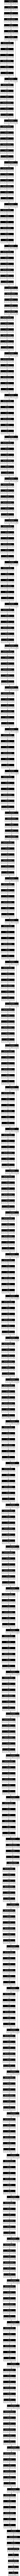

In [38]:
tf.keras.utils.plot_model(model_ft, show_shapes=True)

# Training


In [39]:
history_ft = model_ft.fit(train_ds,
                       epochs = 10,
                       validation_data = valid_ds,
                       )

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-04-09 07:19:11.784288: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[64,3,7,7]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,3,256,256]{3,2,1,0}, f32[64,64,128,128]{3,2,1,0}), window={size=7x7 stride=2x2 pad=3_3x3_3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-04-09 07:19:11.830980: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.046790326s
Trying algorithm eng0{} for conv 

84/94 ━━━━━━━━━━━━━━━━━━━━ 6s 696ms/step - accuracy: 0.7088 - loss: 0.6884

W0000 00:00:1712647442.108091     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7154 - loss: 0.6716

W0000 00:00:1712647459.743139     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 454s 2s/step - accuracy: 0.7160 - loss: 0.6701 - val_accuracy: 0.5067 - val_loss: 12.4648
Epoch 2/10


W0000 00:00:1712647472.399144     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 71s 734ms/step - accuracy: 0.8813 - loss: 0.2659 - val_accuracy: 0.7058 - val_loss: 1.5659
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 71s 736ms/step - accuracy: 0.9379 - loss: 0.1618 - val_accuracy: 0.8792 - val_loss: 0.3284
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 72s 730ms/step - accuracy: 0.9457 - loss: 0.1284 - val_accuracy: 0.9233 - val_loss: 0.2212
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 70s 728ms/step - accuracy: 0.9644 - loss: 0.0872 - val_accuracy: 0.9175 - val_loss: 0.2410
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 70s 732ms/step - accuracy: 0.9763 - loss: 0.0606 - val_accuracy: 0.8950 - val_loss: 0.3213
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 70s 732ms/step - accuracy: 0.9686 - loss: 0.0797 - val_accuracy: 0.7458 - val_loss: 0.9733
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 70s 731ms/step - accuracy: 0.9757 - loss: 0.0639 - val_accuracy: 0.7408 - val_loss: 1.3344
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 70s 729ms/step - accuracy: 0.9839 - loss: 0.0480 - val_accuracy: 0.880

# Results


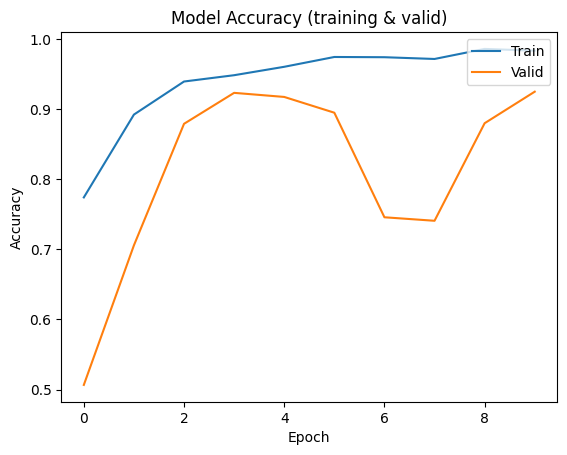

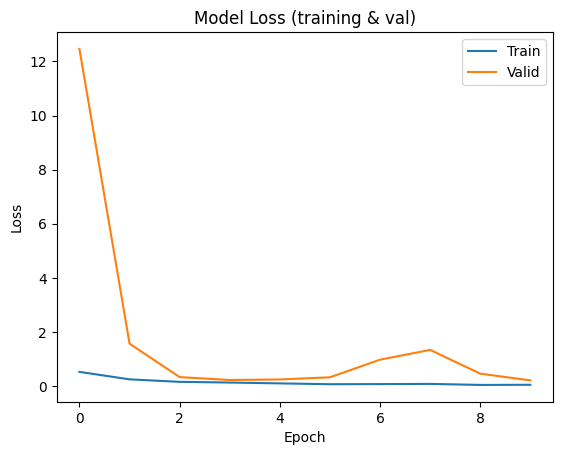

In [40]:
plt.plot(history_ft.history['accuracy'])
plt.plot(history_ft.history['val_accuracy'])
plt.title('Model Accuracy (training & valid)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper right')
plt.show()


plt.plot(history_ft.history['loss'])
plt.plot(history_ft.history['val_loss'])
plt.title('Model Loss (training & val)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper right')
plt.show()

In [41]:
# Evaluate the model on the test set
test_loss, test_acc = model_ft.evaluate(test_ds)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

11/11 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.9179 - loss: 0.2263 
Test Loss: 0.22284826636314392
Test Accuracy: 0.917664647102356


W0000 00:00:1712648190.328475     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


# Image example - Qualitative results


Let's try the model on a real image. It is very confident (99.96%) that it is a real one.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Text(0.5, 1.0, 'This image is 99.99% Fake and 0.01% Real.')

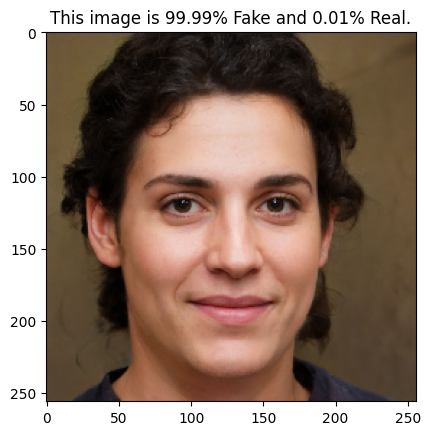

In [54]:

image_url = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTLRG6koBKzFaA-Itv6_wm1SIvpLrJPM001Sw&s'
image_url = tf.keras.utils.get_file('Court', origin=image_url )
test_image = tf.keras.preprocessing.image.load_img(image_url, target_size=(256, 256, 3))

#img = keras.preprocessing.image.load_img( image_url, target_size=( 224, 224 ) )

#real example
# test_image = tf.keras.preprocessing.image.load_img('/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test/real/00343.jpg', target_size=(256, 256, 3))
plt.imshow(test_image)


test_image_arr = tf.keras.preprocessing.image.img_to_array(test_image)
test_image_arr = np.expand_dims(test_image, axis=0)
test_image_arr = test_image_arr/255.


result = model_ft.predict(test_image_arr)

plt.title(f"This image is {100 * (1 - result[0][0]):.2f}% Fake and {100 * result[0][0]:.2f}% Real.")


The result score is near 1 if the image is **real** and 0 if the image is **fake**.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


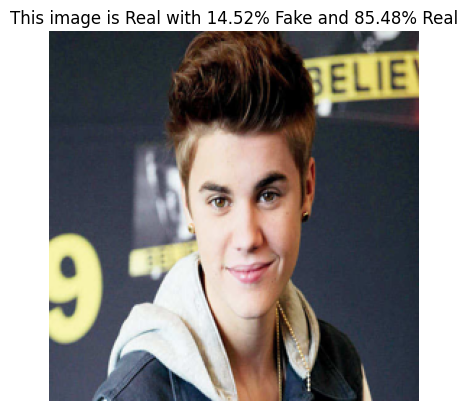

In [56]:
import requests
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
from io import BytesIO

# Specify the image URL you want to load
image_url = 'https://static.toiimg.com/thumb/imgsize-23456,msid-16336202,width-600,resizemode-4/16336202.jpg'

# Download the image from the URL
response = requests.get(image_url)
image = Image.open(BytesIO(response.content))

# Resize the image to the target size (256x256) for processing
image = image.resize((256, 256))

# Convert the PIL Image to a numpy array and normalize pixel values
image_array = np.array(image) / 255.0  # Scale pixel values to [0, 1]

# Expand dimensions to match the model input shape (add batch dimension)
image_array = np.expand_dims(image_array, axis=0)

# Assuming model_ft is your pre-trained detection model
result = model_ft.predict(image_array)

# Determine the prediction label and confidence
is_fake = result[0][0] < 0.5
confidence_real = 100 * result[0][0]
confidence_fake = 100 * (1 - result[0][0])

# Display the image and prediction result using matplotlib
plt.imshow(image)
plt.title(f"This image is {'Fake' if is_fake else 'Real'} "
          f"with {confidence_fake:.2f}% Fake and {confidence_real:.2f}% Real")
plt.axis('off')  # Hide axis labels
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


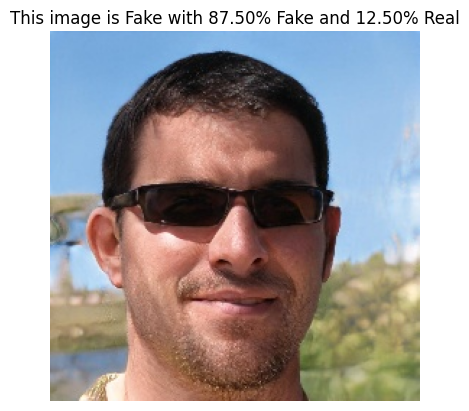

In [59]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image

# Define the path to the image on your local computer
image_path = '/kaggle/input/fake-images/dataset/test/fake/00PB1BNIE8.jpg'  # Replace this with the path to your image

# Load the image using PIL (Python Imaging Library)
image = Image.open(image_path)

# Resize the image to the target size (256x256) for processing
image = image.resize((256, 256))

# Convert the PIL Image to a numpy array and normalize pixel values
image_array = np.array(image) / 255.0  # Scale pixel values to [0, 1]

# Expand dimensions to match the model input shape (add batch dimension)
image_array = np.expand_dims(image_array, axis=0)

# Assuming model_ft is your pre-trained detection model
result = model_ft.predict(image_array)

# Determine the prediction label and confidence
is_fake = result[0][0] < 0.5
confidence_real = 100 * result[0][0]
confidence_fake = 100 * (1 - result[0][0])

# Display the selected image and prediction result using matplotlib
plt.imshow(image)
plt.title(f"This image is {'Fake' if is_fake else 'Real'} "
          f"with {confidence_fake:.2f}% Fake and {confidence_real:.2f}% Real")
plt.axis('off')  # Hide axis labels
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


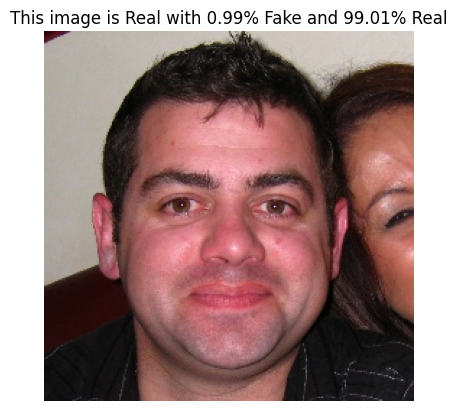

In [60]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image

# Define the path to the image on your local computer
image_path = '/kaggle/input/fake-images/dataset/test/real/00016.jpg'  # Replace this with the path to your image

# Load the image using PIL (Python Imaging Library)
image = Image.open(image_path)

# Resize the image to the target size (256x256) for processing
image = image.resize((256, 256))

# Convert the PIL Image to a numpy array and normalize pixel values
image_array = np.array(image) / 255.0  # Scale pixel values to [0, 1]

# Expand dimensions to match the model input shape (add batch dimension)
image_array = np.expand_dims(image_array, axis=0)

# Assuming model_ft is your pre-trained detection model
result = model_ft.predict(image_array)

# Determine the prediction label and confidence
is_fake = result[0][0] < 0.5
confidence_real = 100 * result[0][0]
confidence_fake = 100 * (1 - result[0][0])

# Display the selected image and prediction result using matplotlib
plt.imshow(image)
plt.title(f"This image is {'Fake' if is_fake else 'Real'} "
          f"with {confidence_fake:.2f}% Fake and {confidence_real:.2f}% Real")
plt.axis('off')  # Hide axis labels
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


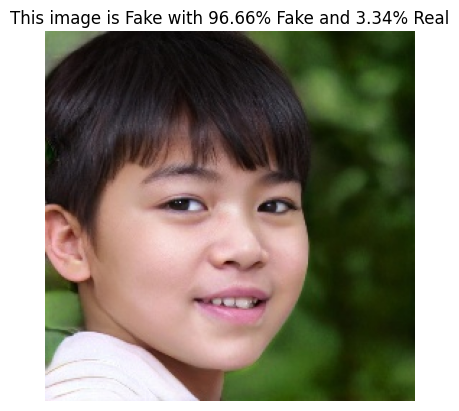

In [61]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image

# Define the path to the image on your local computer
image_path = '/kaggle/input/fake-images/dataset/validation/fake/00W5NPIX4S.jpg'  # Replace this with the path to your image

# Load the image using PIL (Python Imaging Library)
image = Image.open(image_path)

# Resize the image to the target size (256x256) for processing
image = image.resize((256, 256))

# Convert the PIL Image to a numpy array and normalize pixel values
image_array = np.array(image) / 255.0  # Scale pixel values to [0, 1]

# Expand dimensions to match the model input shape (add batch dimension)
image_array = np.expand_dims(image_array, axis=0)

# Assuming model_ft is your pre-trained detection model
result = model_ft.predict(image_array)

# Determine the prediction label and confidence
is_fake = result[0][0] < 0.5
confidence_real = 100 * result[0][0]
confidence_fake = 100 * (1 - result[0][0])

# Display the selected image and prediction result using matplotlib
plt.imshow(image)
plt.title(f"This image is {'Fake' if is_fake else 'Real'} "
          f"with {confidence_fake:.2f}% Fake and {confidence_real:.2f}% Real")
plt.axis('off')  # Hide axis labels
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


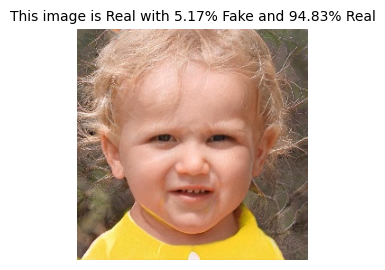

In [69]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image

# Define the path to the image on your local computer
image_path = '/kaggle/input/fake-images/dataset/validation/fake/0C1ILMRZGO.jpg'  # Replace this with the path to your image

# Load the image using PIL (Python Imaging Library)
image = Image.open(image_path)

# Resize the image to the target size (256x256) for processing
image = image.resize((256, 256))

# Convert the PIL Image to a numpy array and normalize pixel values
image_array = np.array(image) / 255.0  # Scale pixel values to [0, 1]

# Expand dimensions to match the model input shape (add batch dimension)
image_array = np.expand_dims(image_array, axis=0)

# Assuming model_ft is your pre-trained detection model
result = model_ft.predict(image_array)

# Determine the prediction label and confidence
is_fake = result[0][0] < 0.5
confidence_real = 100 * result[0][0]
confidence_fake = 100 * (1 - result[0][0])

# Display the selected image and prediction result using matplotlib
plt.figure(figsize=(3, 3))
plt.imshow(image)
plt.title(f"This image is {'Fake' if is_fake else 'Real'} "
          f"with {confidence_fake:.2f}% Fake and {confidence_real:.2f}% Real",fontsize=10)
plt.axis('off')  # Hide axis labels
plt.show()


# Quantitative results


In [27]:
# Assuming you have defined your model as 'model'
predicted_labels = model.predict(test_ds)

 2/11 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step

W0000 00:00:1711972551.717807     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


11/11 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step 


W0000 00:00:1711972564.471783     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [30]:
true_labels = test_ds.classes

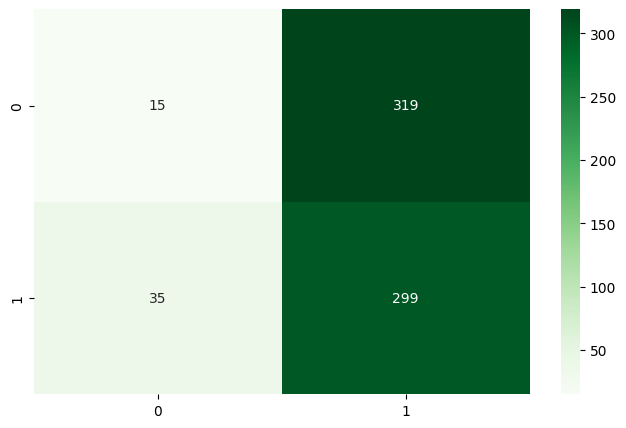

In [31]:
plt.figure(figsize = (8,5))
sns.heatmap(metrics.confusion_matrix(true_labels, predicted_labels.round()), annot = True,fmt="d",cmap = "Greens")
plt.show()

In [32]:
metrics.accuracy_score(true_labels, predicted_labels.round())

0.47005988023952094

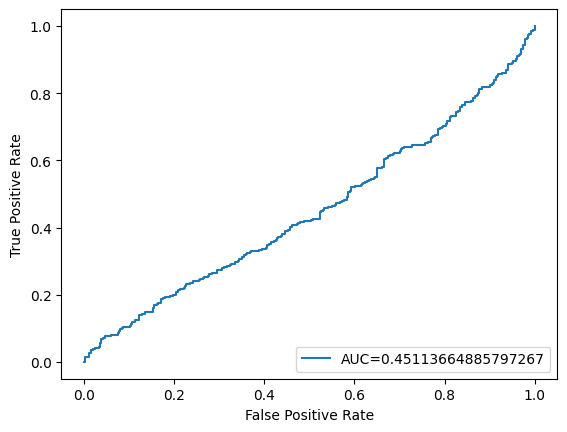

In [33]:
fpr, tpr, _ = metrics.roc_curve(true_labels,  predicted_labels)
auc = metrics.roc_auc_score(true_labels, predicted_labels)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

# END :)
